![logo](download.png)

### This project is centered around the question of IF we can use historial data from the NBA since 1980 to predict a players career PTS output. More specifically -- can we use a players rookie year stats to determine what their final total points total will be -- PTS being an encompassing metric of a players value in the league. 

### Ultimately, we can use a player's rookie year stats to predict whether or not that player will be above average or below average in scoring by the end of their career. This way - teams can be aware of potential 'sophomore slumps' and 'flops' in the draft. 

    1) Importing / Cleaning
    2) Explore data
    3) Feature Selection
    4) Training / Test Split & Resampling
    5) Machine Learning & Classification Algorithms

In [590]:
#Packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#from scipy import stats
%matplotlib inline 
sns.set(color_codes=True)

#Machine Learning
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFE

#classifier evaluation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# i) Importing/Cleaning

In [544]:
#import .csv file
season_df = pd.read_csv("nba_seasons.csv", index_col=0)

In [545]:
print(season_df.shape)
season_df.head(3)

(24691, 52)


,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0


##### Check for NAN 

In [546]:
#check NAN from season_df columns
season_df.isna().sum()

Year         67
Player       67
Pos          67
Age          75
Tm           67
G            67
GS         6458
MP          553
PER         590
TS%         153
3PAr       5852
FTr         166
ORB%       3899
DRB%       3899
TRB%       3120
AST%       2136
STL%       3899
BLK%       3899
TOV%       5109
USG%       5051
blanl     24691
OWS         106
DWS         106
WS          106
WS/48       590
blank2    24691
OBPM       3894
DBPM       3894
BPM        3894
VORP       3894
FG           67
FGA          67
FG%         166
3P         5764
3PA        5764
3P%        9275
2P           67
2PA          67
2P%         195
eFG%        166
FT           67
FTA          67
FT%         925
ORB        3894
DRB        3894
TRB         379
AST          67
STL        3894
BLK        3894
TOV        5046
PF           67
PTS          67
dtype: int64

In [547]:
#drop empty columns (50 expected)
season_df.drop(['blanl'], axis=1, inplace=True)
season_df.drop(['blank2'], axis=1, inplace=True)

#check
print(season_df.shape)

(24691, 50)


In [548]:
#drop rows with NAN values
season_df.dropna(inplace=True)
print(season_df.shape)
season_df.head(3)

(14585, 50)


,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
5730,1980.0,Tiny Archibald*,PG,31.0,BOS,80.0,80.0,2864.0,15.3,0.574,...,0.830,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0
5748,1980.0,Larry Bird*,PF,23.0,BOS,82.0,82.0,2955.0,20.5,0.538,...,0.836,216.0,636.0,852.0,370.0,143.0,53.0,263.0,279.0,1745.0
5781,1980.0,M.L. Carr,SF,29.0,BOS,82.0,7.0,1994.0,14.6,0.526,...,0.739,106.0,224.0,330.0,156.0,120.0,36.0,143.0,214.0,914.0


In [549]:
nba_df = season_df[['Player',
                    'FG',
                    'FGA',
                    'FG%',
                    '3P',
                    '3PA',
                    '3P%',
                    '2P',
                    '2PA',
                    '2P%',
                    'eFG%',
                    'FT',
                    'FTA',
                    'FT%',
                    'ORB',
                    'DRB',
                    'TRB',
                    'AST',
                    'STL',
                    'BLK',
                    'TOV',
                    'PF',
                    'PTS']]

In [550]:
print(nba_df.shape)
nba_df.head(1)
nba_df = nba_df.reset_index(drop=True)

(14585, 23)


##### combining duplicates into career stats

In [551]:
aggregation_functions = {'FG': 'mean',
                         'FGA': 'mean',
                         'FG%': 'mean',
                         '3P': 'mean',
                         '3PA': 'mean',
                         '3P%': 'mean',
                         '2P': 'mean',
                         '2PA': 'mean',
                         '2P%': 'mean',
                         'eFG%': 'mean',
                         'FT': 'mean',
                         'FTA': 'mean',
                         'FT%': 'mean',
                         'ORB': 'mean',
                         'DRB': 'mean',
                         'TRB': 'mean',
                         'AST': 'mean',
                         'STL': 'mean',
                         'BLK': 'mean',
                         'TOV': 'mean',
                         'PF': 'mean',
                         'PTS': 'sum'}

career_df = nba_df.groupby(nba_df['Player']).aggregate(aggregation_functions)
print(career_df.shape)
career_df.head(1)

(2331, 22)


,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green,265.444444,538.111111,0.487667,6.944444,28.277778,0.146833,258.5,509.833333,0.501889,0.493167,...,0.708056,198.666667,364.055556,562.722222,81.611111,61.277778,31.222222,83.777778,143.388889,12928.0


In [552]:
#rename PTS columns into Career PTS
career_df.rename(columns = {'PTS':'TOTAL_PTS'}, inplace = True) 

career_df = career_df.round(decimals=1)
career_df.head(1)

,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,TOTAL_PTS
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green,265.4,538.1,0.5,6.9,28.3,0.1,258.5,509.8,0.5,0.5,...,0.7,198.7,364.1,562.7,81.6,61.3,31.2,83.8,143.4,12928.0


##### aggregating nba_df into rookie years 

In [553]:
aggregation_functions = {'FG': 'first',
                         'FGA': 'first',
                         'FG%': 'first',
                         '3P': 'first',
                         '3PA': 'first',
                         '3P%': 'first',
                         '2P': 'first',
                         '2PA': 'first',
                         '2P%': 'first',
                         'eFG%': 'first',
                         'FT': 'first',
                         'FTA': 'first',
                         'FT%': 'first',
                         'ORB': 'first',
                         'DRB': 'first',
                         'TRB': 'first',
                         'AST': 'first',
                         'STL': 'first',
                         'BLK': 'first',
                         'TOV': 'first',
                         'PF': 'first',
                         'PTS': 'first'}

rookie_df = nba_df.groupby(nba_df['Player']).aggregate(aggregation_functions)
print(rookie_df.shape)
rookie_df.head(3)

(2331, 22)


,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green,209.0,388.0,0.539,1.0,6.0,0.167,208.0,382.0,0.545,0.540,...,0.611,160.0,221.0,381.0,54.0,49.0,49.0,99.0,229.0,521.0
A.J. English,251.0,572.0,0.439,3.0,31.0,0.097,248.0,541.0,0.458,0.441,...,0.707,66.0,81.0,147.0,177.0,25.0,15.0,114.0,127.0,616.0
A.J. Guyton,78.0,192.0,0.406,27.0,69.0,0.391,51.0,123.0,0.415,0.477,...,0.833,10.0,26.0,36.0,64.0,9.0,5.0,24.0,35.0,198.0


##### combine career total pts with rookie_df

In [554]:
total_df = career_df[['TOTAL_PTS']]
total_df.head(3)

,TOTAL_PTS
Player,
A.C. Green,12928.0
A.J. English,1502.0
A.J. Guyton,442.0


In [555]:
#merge with rookie_df
stats_df = pd.merge(rookie_df, total_df, on='Player')
stats_df.head(3)

,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TOTAL_PTS
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green,209.0,388.0,0.539,1.0,6.0,0.167,208.0,382.0,0.545,0.540,...,160.0,221.0,381.0,54.0,49.0,49.0,99.0,229.0,521.0,12928.0
A.J. English,251.0,572.0,0.439,3.0,31.0,0.097,248.0,541.0,0.458,0.441,...,66.0,81.0,147.0,177.0,25.0,15.0,114.0,127.0,616.0,1502.0
A.J. Guyton,78.0,192.0,0.406,27.0,69.0,0.391,51.0,123.0,0.415,0.477,...,10.0,26.0,36.0,64.0,9.0,5.0,24.0,35.0,198.0,442.0


# ii) Explore Data

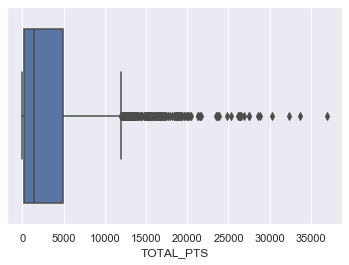

In [556]:
sns.boxplot(x=stats_df['TOTAL_PTS'])

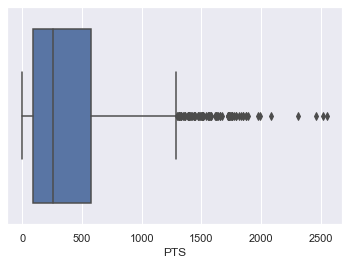

In [557]:
sns.boxplot(x=stats_df['PTS'])

# iii) Feature Selection

In [558]:
array = stats_df.values
X = array[:,0:21]
Y = array[:,21]

##### Feature selection chose (#FG, FG%, 3P, 3P%, 2P, 2P%, eFG%, FT, FT%) as the top-9 features. This makes sense since our dependent variable is total_points scored in a career. 

In [559]:
# feature extraction
model = LinearRegression()
rfe = RFE(model, 9)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 9
Selected Features: [ True False  True  True False  True  True False  True  True  True False
  True False False False False False False False False]
Feature Ranking: [ 1  2  1  1  4  1  1  7  1  1  1 11  1  3  5  6 10  8 13 12  9]


In [560]:
final_df = stats_df[['FG', 'FG%', '3P', '3P%', '2P', '2P%', 'eFG%', 'FT', 'FT%', 'TOTAL_PTS']]
print(final_df.shape)
final_df.head()

(2331, 10)


,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,TOTAL_PTS
Player,,,,,,,,,,
A.C. Green,209.0,0.539,1.0,0.167,208.0,0.545,0.540,102.0,0.611,12928.0
A.J. English,251.0,0.439,3.0,0.097,248.0,0.458,0.441,111.0,0.707,1502.0
A.J. Guyton,78.0,0.406,27.0,0.391,51.0,0.415,0.477,15.0,0.833,442.0
A.J. Hammons,17.0,0.405,5.0,0.500,12.0,0.375,0.464,9.0,0.450,48.0
A.J. Price,145.0,0.410,60.0,0.345,85.0,0.472,0.494,60.0,0.800,1650.0


In [561]:
#find the mean total_pts since 1980 
final_df['TOTAL_PTS'].mean()

3523.7001287001285

##### classify player total points as either 1/0 -- Above Average/Below Average

In [562]:
final_df['TOTAL_PTS'].values[final_df['TOTAL_PTS'] < 3522] = 0
final_df['TOTAL_PTS'].values[final_df['TOTAL_PTS'] >= 3523] = 1
final_df.head()

,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,TOTAL_PTS
Player,,,,,,,,,,
A.C. Green,209.0,0.539,1.0,0.167,208.0,0.545,0.540,102.0,0.611,1.0
A.J. English,251.0,0.439,3.0,0.097,248.0,0.458,0.441,111.0,0.707,0.0
A.J. Guyton,78.0,0.406,27.0,0.391,51.0,0.415,0.477,15.0,0.833,0.0
A.J. Hammons,17.0,0.405,5.0,0.500,12.0,0.375,0.464,9.0,0.450,0.0
A.J. Price,145.0,0.410,60.0,0.345,85.0,0.472,0.494,60.0,0.800,0.0


In [563]:
#change total_pts column (y-dependent-variable) into a binary variable 
final_df['TOTAL_PTS'].value_counts()

0.0    1589
1.0     742
Name: TOTAL_PTS, dtype: int64

In [564]:
#write stats_df to a .csv
final_df.to_csv('stats_data.csv')

# iv) Training/Test Split & Resampling

In [565]:
#split into TRAIN/TEST
msk = np.random.rand(len(final_df)) < 0.70

train_df = final_df[msk]
test_df = final_df[~msk]

In [566]:
print(len(test_df))
print(len(train_df))

695
1636


In [567]:
#split test into X_test and y_test for later
y_test = test_df['TOTAL_PTS']
X_test = test_df.drop('TOTAL_PTS',axis=1)

### Random Oversampling

In [568]:
train_df.TOTAL_PTS.value_counts()

0.0    1125
1.0     511
Name: TOTAL_PTS, dtype: int64

In [569]:
#class count
count_class_0, count_class_1 = train_df.TOTAL_PTS.value_counts()

#divide by class
df_class_0 = train_df[train_df['TOTAL_PTS'] == 0]
df_class_1 = train_df[train_df['TOTAL_PTS'] == 1]

Random over-sampling:
0.0    1125
1.0    1125
Name: TOTAL_PTS, dtype: int64


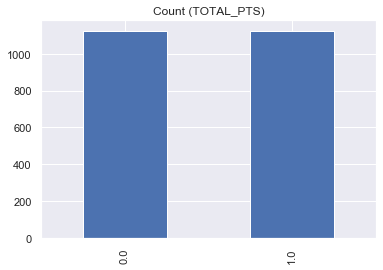

In [570]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_1_over, df_class_0], axis=0)

print('Random over-sampling:')
print(df_test_over.TOTAL_PTS.value_counts())

df_test_over.TOTAL_PTS.value_counts().plot(kind='bar', title='Count (TOTAL_PTS)')

### Random Undersampling

Random undersampling:
1.0    511
0.0    511
Name: TOTAL_PTS, dtype: int64


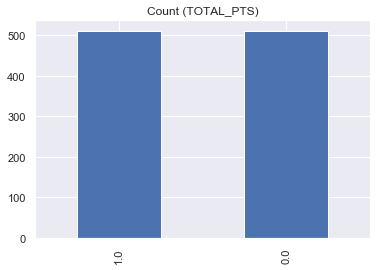

In [571]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random undersampling:')
print(df_test_under.TOTAL_PTS.value_counts())

df_test_under.TOTAL_PTS.value_counts().plot(kind='bar', title='Count (TOTAL_PTS)')

# v) Machine Learning & Classification

In [572]:
#split into X_train and y_train
y_train = train_df['TOTAL_PTS']
X_train = train_df.drop('TOTAL_PTS',axis=1)

### Oversampled Data

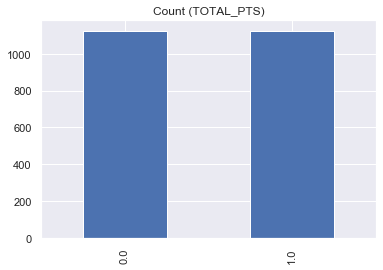

In [573]:
df2_test_over = pd.DataFrame(df_test_over)
df2_test_over.TOTAL_PTS.value_counts().plot(kind='bar', title='Count (TOTAL_PTS)');

In [574]:
#split into X_train and y_train
X_over_train = df2_test_over.drop('TOTAL_PTS',axis=1)
y_over_train = df2_test_over['TOTAL_PTS']

#### Naive Bayes Classifier

In [575]:
##fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(X_over_train, y_over_train)

#predicting the test set results
predictions = nb_classifier.predict(X_test)

Confusion matrix:
 [[292 172]
 [ 97 134]]


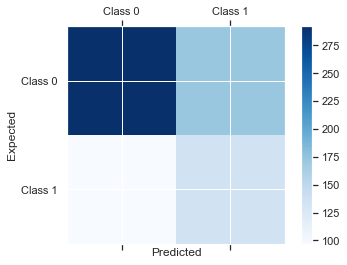

In [576]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [578]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 61.29%
 Precision: 43.79%
    Recall: 58.01%
  F1 score: 49.91%
 ROC score: 60.47%


#### Logistic Regression 

In [584]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'liblinear')
reg_classifier.fit(X_over_train, y_over_train)

#predicting the test set results
predictions = reg_classifier.predict(X_test)

Confusion matrix:
 [[365  99]
 [ 63 168]]


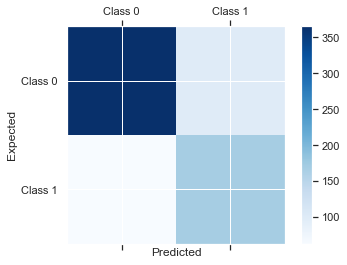

In [585]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [586]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 76.69%
 Precision: 62.92%
    Recall: 72.73%
  F1 score: 67.47%
 ROC score: 75.70%


##### K-Nearest Neighbours

In [613]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 20, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, X_over_train, y_over_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 1


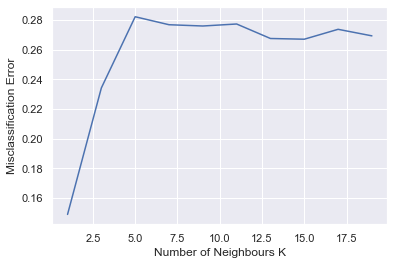

In [614]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [639]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 1, weights = 'distance', algorithm = 'auto')
knn_classifier.fit(X_over_train, y_over_train)

#predicting the test set results
predictions = knn_classifier.predict(X_test)

Confusion matrix:
 [[384  80]
 [121 110]]


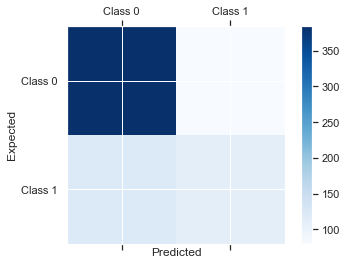

In [640]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()


In [641]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 71.08%
 Precision: 57.89%
    Recall: 47.62%
  F1 score: 52.26%
 ROC score: 65.19%


##### Support Vector Machine

In [642]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='perceptron', penalty='l2')
svm_classifier.fit(X_over_train, y_over_train)

#predicting the test set results
predictions = svm_classifier.predict(X_test)

Confusion matrix:
 [[330 134]
 [ 50 181]]


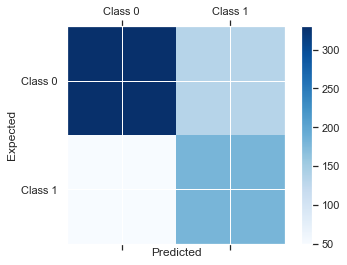

In [643]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [644]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 73.53%
 Precision: 57.46%
    Recall: 78.35%
  F1 score: 66.30%
 ROC score: 74.74%


### Undersampled Data

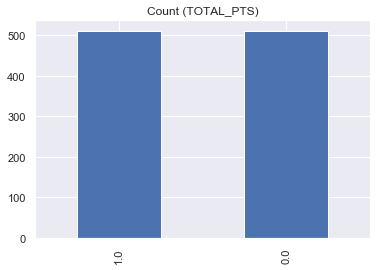

In [646]:
df2_test_under = pd.DataFrame(df_test_under)
df2_test_under.TOTAL_PTS.value_counts().plot(kind='bar', title='Count (TOTAL_PTS)')

In [647]:
#split into X_train and y_train
X_under_train = df2_test_under.drop('TOTAL_PTS',axis=1)
y_under_train = df2_test_under['TOTAL_PTS']

In [648]:
#fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(X_under_train, y_under_train)

#predicting the test set results
predictions = nb_classifier.predict(X_test)

Confusion matrix:
 [[278 186]
 [ 95 136]]


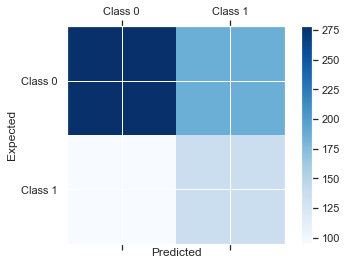

In [649]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [650]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 59.57%
 Precision: 42.24%
    Recall: 58.87%
  F1 score: 49.19%
 ROC score: 59.39%


### Logistic Regression

In [651]:
#fitting Logistic Regression to the training set
reg_classifier = LogisticRegression(penalty = 'l2', solver = 'liblinear')
reg_classifier.fit(X_under_train, y_under_train)

#predicting the test set results
predictions = reg_classifier.predict(X_test)

Confusion matrix:
 [[365  99]
 [ 63 168]]


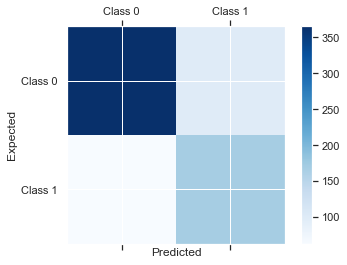

In [653]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [654]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 76.69%
 Precision: 62.92%
    Recall: 72.73%
  F1 score: 67.47%
 ROC score: 75.70%


### K-Nearest Neighbours

In [657]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 100, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, X_under_train, y_under_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 47


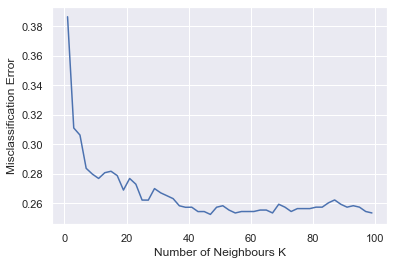

In [658]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [659]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 47, weights = 'distance', algorithm = 'auto')
knn_classifier.fit(X_under_train, y_under_train)

#predicting the test set results
predictions = knn_classifier.predict(X_test)

Confusion matrix:
 [[360 104]
 [ 73 158]]


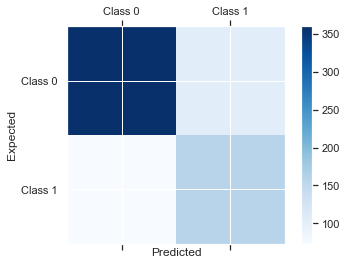

In [660]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [661]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 74.53%
 Precision: 60.31%
    Recall: 68.40%
  F1 score: 64.10%
 ROC score: 72.99%


### Support Vector Machine

In [662]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='perceptron', penalty='l2')
svm_classifier.fit(X_under_train, y_under_train)

#predicting the test set results
predictions = svm_classifier.predict(X_test)

Confusion matrix:
 [[237 227]
 [ 29 202]]


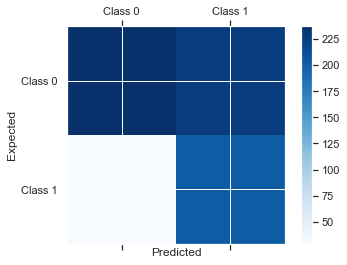

In [663]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [664]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

#ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = (auc(false_positive_rate, true_positive_rate)).astype('float64')
print('{:>10}: {:0.2%}'.format('ROC score',roc_auc))

  Accuracy: 63.17%
 Precision: 47.09%
    Recall: 87.45%
  F1 score: 61.21%
 ROC score: 69.26%
